## Codificación por la Tasa de Probabilidad

En las lecciones anteriores de esta sección, vimos como convertir una etiqueta en un número usando codificación one-hot, reemplazando por un dígito o reemplazando por la frecuencia o número de observaciones. Estos métodos son sencillos, y no (o casi nunca) hacen supuestos sobre los datos y funcionan generalmente bien en una variedad de escenarios.

Hay métodos que por el contrario si permiten capturar  información y a la vez pre-procesar las etiquetas de una variable categórica. Estos métodos incluyen:

- Ordenar las etiquetas de acuerdo al target
- Reemplazar las etiquetas por el promedio del target (codificación por la media / por el target) 
- Reemplazar las etiquetas por el radio de probabilidad del target - ya sea 1 o 0
- Pesos de evidencia (Weight of evidence)

Todos estos métodos tienen algo en común:
- la codificación es **guiada por el target**, y
- crean una **relación monotónica** entre la variable y el target


### Monotonicidad

Una relación monotónica es una relación que tiene lo siguiente:

- (1) cuando el valor de una variable incrementa, asi mismo sucede con la otra variable; o
- (2) cuando el valor de una variable incrementa, el valor de la otra variable decrece.

En este caso, si el valor de la variable independiente (predictor) incrementa, lo mismo sucede con el target (variable objetivo), o por el contrario, si la variable incrementa, el valor del target decrece.


### Ventajas 

- Captura la información dentro de la categoría, por lo tanto incrementa el poder predictivo de las variables.
- Crea una relación monotónica entre la variable y el target, por lo tanto es adecuada para modelos lineales.
- No expande el espacio de las variables


### Limitaciones

- Tiende a causar sobreajustes
- Es difícil de validar usando las librerías existentes

### Nota

Los métodos discutidos en esta y las próximas 3 lecciones pueden ser usados con variables numéricas, luego de discretizarlas. Esto crea una relación monotónica entre la variable numérica y el target y por lo tanto mejora el desempeño de los modelos lineales. Discutiremos esto en más detalle en la sección "Discretización"


===============================================================================

## Codificación por la Tasa de Probabilidad

Este tipo de codificación se puede usar solamente para problemas de clasificación, donde el target es binario.

Por cada categoría, calculamos el promedio que el target = 1, es decir, la probabilidad de que el target sea 1 ( P(1) ), y la probabilidad de que el target = 0 ( P(0) ). Y luego calculamos la proporción P(1)/P(0) y reemplazamos las categorías por esta tasa.


## En este demo:

Vamos a ver como calcular esta codificación usando:
- pandas
- Feature-Engine

y las ventajas y limitaciones de cada una de estas implementaciones usando los datos del Titanic.



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# separar el datasets
from sklearn.model_selection import train_test_split

# codificación con feature-engine
from feature_engine.encoding import PRatioEncoder as WoERatioCategoricalEncoder

In [2]:
# cargar los datos

data = pd.read_csv(
    '../titanic.csv',
    usecols=['cabin', 'sex', 'embarked', 'survived'])

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [3]:
# removamos las observaciones con datos ausentes na en embarked

data.dropna(subset=['embarked'], inplace=True)
data.shape

(1307, 4)

In [4]:
# Ahora reemplazamos los valores de la variable cabin 
# con la primera letra de cada una de sus etiquetas. 
# De esta forma simplificamos los valores en la variable 
# y facilitamos el demo 

data['cabin'] = data['cabin'].astype(str).str[0]

In [5]:
# removemos las observaciones donde cabin = T
# ya que solo son unas pocas

data = data[data['cabin']!= 'T']
data.shape

(1306, 4)

In [6]:
# miremos cuantas categorías tiene cada variable

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' etiquetas')

survived :  2  etiquetas
sex :  2  etiquetas
cabin :  8  etiquetas
embarked :  3  etiquetas


In [7]:
# exploremos las categorías de cada variable
data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'F', 'G'], dtype=object)

In [8]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [9]:
data['embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

### Importante

Calculamos la tasa  P(1)/P(0) usando el set de entrenamiento, y luego usamos ese mapeo en el set de prueba.

Para implementarlo en pandas, tenemos que mantener el target en el set de entrenamiento.

In [10]:
# separemos en sets de prueba y entrenamiento

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']],  # esta vez mantenemos el target en la variable
    data['survived'],  # target
    test_size=0.3,  # porcentaje de observaciones en el set de prueba
    random_state=0)  # semilla asegurar reproducibilidad

X_train.shape, X_test.shape

((914, 4), (392, 4))

### Exploremos la relación original entre las variables categóricas y el target

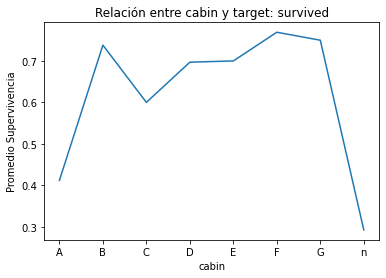

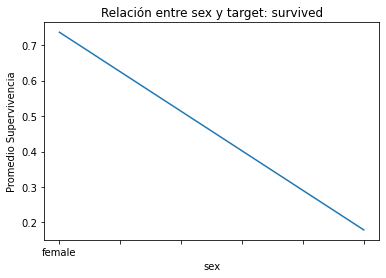

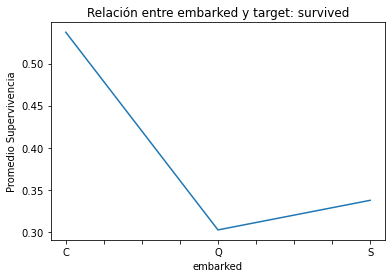

In [11]:
# Exploremos la relación original entre las variables categóricas 
# y el target survived

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relación entre {} y target: survived'.format(var))
    fig.set_ylabel('Promedio Supervivencia')
    plt.show()

Podemos ver en la relación entre el target y las variables cabin/embarked, que esta sube y baja dependiendo de la categoría. 

## Codificación por la Tasa de Probabilidad con pandas

### Ventajas

- rápido
- retorna un dataframe de pandas

### Limitaciones de pandas:

- no preserva la información del set de entrenamiento para propagarlo al set de prueba

Necesitamos capturar y guardar los mapeos uno por uno, manualmente, si estamos planeando usarlos en producción


In [12]:
# calculemos la probabilidad de survived = 1 por cada categoría

prob_df = X_train.groupby(['cabin'])['survived'].mean()

# capturemos en un dataframe
prob_df = pd.DataFrame(prob_df)
prob_df

,survived
cabin,
A,0.411765
B,0.738095
C,0.600000
D,0.696970
E,0.700000
F,0.769231
G,0.750000
n,0.292199


In [13]:
# y ahora la probabilidad de survived = 0
# esta es la probabilidad que el pasajero haya muerto (died)

prob_df['died'] = 1 - prob_df['survived']

prob_df

,survived,died
cabin,,
A,0.411765,0.588235
B,0.738095,0.261905
C,0.600000,0.400000
D,0.696970,0.303030
E,0.700000,0.300000
F,0.769231,0.230769
G,0.750000,0.250000
n,0.292199,0.707801


In [14]:
#  y ahora la calculemos la tasa o proporción

prob_df['ratio'] = prob_df['survived'] / prob_df['died']

prob_df

,survived,died,ratio
cabin,,,
A,0.411765,0.588235,0.700000
B,0.738095,0.261905,2.818182
C,0.600000,0.400000,1.500000
D,0.696970,0.303030,2.300000
E,0.700000,0.300000,2.333333
F,0.769231,0.230769,3.333333
G,0.750000,0.250000,3.000000
n,0.292199,0.707801,0.412826


In [15]:
# y ahora capturemos la proporción en un diccionario 

ordered_labels = prob_df['ratio'].to_dict()

ordered_labels

{'A': 0.7,
 'B': 2.818181818181819,
 'C': 1.4999999999999998,
 'D': 2.3000000000000007,
 'E': 2.333333333333333,
 'F': 3.333333333333334,
 'G': 3.0,
 'n': 0.4128256513026052}

In [16]:
# y ahora reemplazamos cada categoría por la tasa de probabilidad

X_train['cabin'] = X_train['cabin'].map(ordered_labels)
X_test['cabin'] = X_test['cabin'].map(ordered_labels)

In [17]:
# exploremos el resultado

X_train['cabin'].head(10)

843     0.412826
869     0.412826
430     0.412826
481     0.412826
1308    0.412826
456     0.412826
118     2.300000
485     2.300000
297     0.412826
263     2.333333
Name: cabin, dtype: float64

In [18]:
# agrupemos los comandos anteriores en dos funciones

def find_category_mappings(df, variable, target):

    tmp = pd.DataFrame(df.groupby([variable])[target].mean())
    
    tmp['non-target'] = 1 - tmp[target]
    
    tmp['ratio'] = tmp[target] / tmp['non-target']

    return tmp['ratio'].to_dict()


def integer_encode(train, test, variable, ordinal_mapping):

    X_train[variable] = X_train[variable].map(ordinal_mapping)
    X_test[variable] = X_test[variable].map(ordinal_mapping)

In [19]:
# ahora repitamos el proceso (con un ciclo) para cada 
# una de las variables categóricas

for variable in ['sex', 'embarked']:
    
    mappings = find_category_mappings(X_train, variable, 'survived')
    
    integer_encode(X_train, X_test, variable, mappings)

In [20]:
# veamos el resultado

X_train.head()

,cabin,sex,embarked,survived
843,0.412826,0.218107,0.509434,0
869,0.412826,0.218107,0.509434,0
430,0.412826,2.788235,0.509434,1
481,0.412826,2.788235,1.160920,1
1308,0.412826,0.218107,0.509434,0


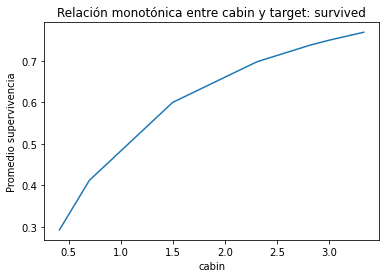

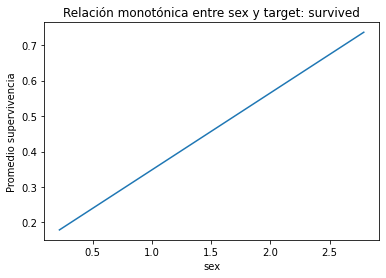

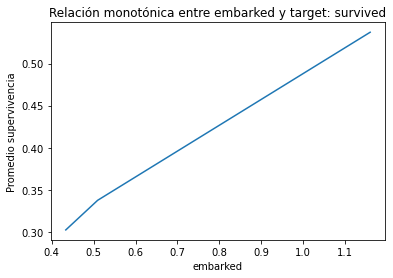

In [21]:
# inspeccionemos la relación monotónica
# entre cada variable y el target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relación monotónica entre {} y target: survived'.format(var))
    fig.set_ylabel('Promedio supervivencia')
    plt.show()

Podemos ver de las gráficas que la relación entre las categorías y el target ahora es monotónica.

### Nota
Reemplazar las etiquetas con el código anterior, va a generar valores faltantes para las categorías presentes en el set de prueba pero que no lo están en el set de entrenamiento. 

Por lo tanto es extremadamente importante, manejar las etiquetas poco comunes con prelación. Explicaremos como hacer esto más adelante en otro notebook.

**Importante: generaremos NA o Inf en los valores de la tasa de probabilidad si la probabilidad que target = 0 es cero, ya que la división por cero no esta definida. **

## Codificación Tasa Probabilidad con Feature-Engine

Si usamos Feature-Engine, en lugar de pandas, no necesitamos mantener el target en el set de entrenamiento.

In [22]:
# separemos en sets de prueba y entrenamiento

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']], # predictores
    data['survived'],  # target
    test_size=0.3,  # porcentaje de observaciones en el set de prueba
    random_state=0)  # semilla asegurar reproducibilidad
X_train.shape, X_test.shape

((914, 3), (392, 3))

In [23]:
ratio_enc = WoERatioCategoricalEncoder(
    encoding_method = 'ratio',
    variables=['cabin', 'sex', 'embarked'])

In [24]:
# cuando ajustamos el transformador, necesitamos pasar 
# el target, al igual que las otras clases de predictores 
# de Scikit-learn 
ratio_enc.fit(X_train, y_train)

PRatioEncoder(variables=['cabin', 'sex', 'embarked'])

In [25]:
# en el atributo encoder_dict_ del encoder podemos ver el 
# valor de P(1)/P(0) asignado a cada una de las categorías 
# por cada variable

ratio_enc.encoder_dict_

{'cabin': {'A': 0.7,
  'B': 2.818181818181819,
  'C': 1.4999999999999998,
  'D': 2.3000000000000007,
  'E': 2.333333333333333,
  'F': 3.333333333333334,
  'G': 3.0,
  'n': 0.4128256513026052},
 'sex': {'female': 2.788235294117647, 'male': 0.21810699588477367},
 'embarked': {'C': 1.160919540229885,
  'Q': 0.4333333333333333,
  'S': 0.5094339622641509}}

In [26]:
# esta es la lista de variables que el codificador transforma
ratio_enc.variables

['cabin', 'sex', 'embarked']

In [27]:
X_train = ratio_enc.transform(X_train)
X_test = ratio_enc.transform(X_test)

# exploremos el resultado
X_train.head()

,cabin,sex,embarked
843,0.412826,0.218107,0.509434
869,0.412826,0.218107,0.509434
430,0.412826,2.788235,0.509434
481,0.412826,2.788235,1.160920
1308,0.412826,0.218107,0.509434


**Nota**

Si el argmento 'variables' se fija en 'None' (ninguno), entonces el codificador automáticamente indentificará  **todas las variables categóricas**. Maravilloso verdad?

El codificador no codificará las variables numéricas. Por lo tanto, si algunas de tus variables categóricas son de hecho numéricas, necesitas hacer el 're-cast' o cambio a tipo 'object' antes de usar el codificador.

Si hay una variable en el set de prueba, para el cual el codificador no tiene un número para asignar ( la categoría no estaba presente en el set de entrenamiento), el codificador devolverá un error para alertarte del problema.

Finalmente, si la probabilidad del target = 0 es cero para cualquier categoría, el codificador devolverá un error ya que la división por cero no esta definida.